In [1]:
import pandas as pd
from dateutil.parser import parse
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.metrics import confusion_matrix
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory , ArrayDictionary , StopWordRemover

## Feature engineering client request

In [2]:
def date_detection(doc,fuzzy=True):
    try: 
        parse(doc, fuzzy=fuzzy)
        return True

    except ValueError:
        return False
    except :
        return False
    
def all_caps_detection(doc):
    return (len([word for word in doc if word.isupper()]) > 0)

def contain_digits_detection(doc):
    return any(c.isdigit() for c in doc)

def karacter_detection(doc,char=':'):
    return char in doc
    
def place_detection(doc,char='di'):
    return char in doc
    
def more_than_n_term_detection(doc,n=18):
    return (len(doc) > n)

def text_to_vector(doc):
    return np.array([
            date_detection(doc),
            all_caps_detection(doc),
            contain_digits_detection(doc),
            karacter_detection(doc),
            place_detection(doc),
            more_than_n_term_detection(doc)])+ 0

In [3]:
train = pd.read_csv("./../static/datatrain.csv")
test = pd.read_csv("./../static/datatest.csv")

# Check kelas

In [4]:
train['label'].unique()

array(['other', 'nama', 'pendidikan', 'nama ', 'ttl'], dtype=object)

In [5]:
test['label'].unique()

array(['nama', 'other', 'pendidikan', 'nama ', 'ttl'], dtype=object)

# Fixing typo in kelas `nama+space` to `nama`

In [6]:
train.label = train.label.replace('nama ','nama')
test.label = test.label.replace('nama ','nama')

# Check kelas

In [7]:
train['label'].unique()

array(['other', 'nama', 'pendidikan', 'ttl'], dtype=object)

In [8]:
test['label'].unique()

array(['nama', 'other', 'pendidikan', 'ttl'], dtype=object)

In [9]:
def load_data():
    train = pd.read_csv("./../static/datatrain.csv")
    test = pd.read_csv("./../static/datatest.csv")
    
    train.label = train.label.replace('nama ','nama')
    test.label = test.label.replace('nama ','nama')
    
    return train,test

# plot distribution of kelas

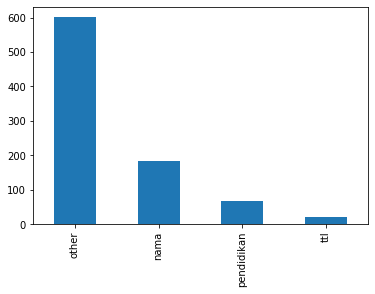

In [10]:
train['label'].value_counts().plot(kind='bar')

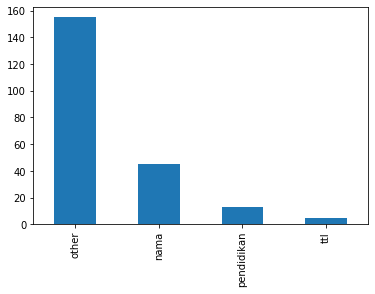

In [11]:
test['label'].value_counts().plot(kind='bar')

# Feature Engineering Sampling

### Downsampling train

In [12]:
def downsampling(train):

    ttl_indices = train[train.label == 'ttl'].index
    random_indices = np.random.choice(ttl_indices, len(ttl_indices), replace=False)
    ttl_sample = train.loc[random_indices]


    other_indices = train[train.label == 'other'].index
    random_indices = np.random.choice(other_indices, len(ttl_indices), replace=False)
    other_sample = train.loc[random_indices]


    nama_indices = train[train.label == 'nama'].index
    random_indices = np.random.choice(nama_indices, len(ttl_indices), replace=False)
    nama_sample = train.loc[random_indices]


    pendidikan_indices = train[train.label == 'pendidikan'].index
    random_indices = np.random.choice(pendidikan_indices, len(ttl_indices), replace=False)
    pendidikan_sample = train.loc[random_indices]

    train_downsampling = pd.concat([ttl_sample,other_sample,nama_sample,pendidikan_sample])
    
    return train_downsampling

### Oversampling Train

In [13]:
def oversampling(train):
    max_size = train['label'].value_counts().max()

    lst = [train]
    for class_index, group in train.groupby('label'):
        lst.append(group.sample(max_size-len(group), replace=True))
    train_oversampling = pd.concat(lst)
    
    return train_oversampling

## test model

In [14]:
def test_model(X_train, y_train, X_test, y_test):
    clf = GaussianNB() 
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    return (accuracy_score(y_test, y_pred))

### Plot

In [15]:
train, test = load_data()
train_oversampling = oversampling(train)
train_downsampling = downsampling(train)

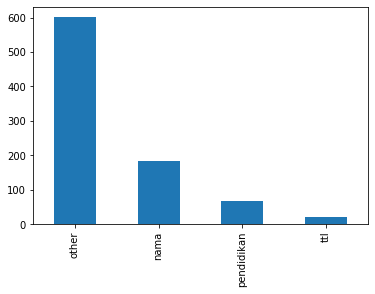

In [16]:
train['label'].value_counts().plot(kind='bar')

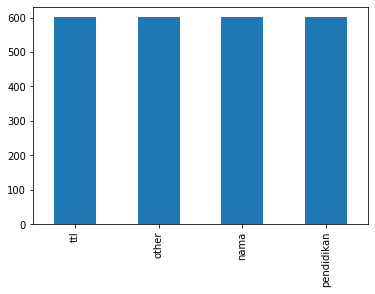

In [17]:
train_oversampling['label'].value_counts().plot(kind='bar')

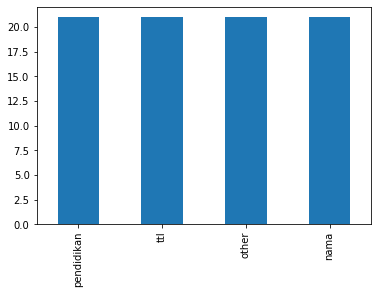

In [18]:
train_downsampling['label'].value_counts().plot(kind='bar')

In [19]:
def testing_fe_1():
    train, test = load_data()
    X_test , y_test = [text_to_vector(i) for i in test["text"]], test['label']
    
    train_nonsampling = train
    train_oversampling = oversampling(train)
    train_downsampling = downsampling(train)

    X_train_over = [text_to_vector(i) for i in train_oversampling["text"]]
    y_train_over = train_oversampling["label"].astype(str)
    X_train_under = [text_to_vector(i) for i in train_downsampling["text"]]
    y_train_under = train_downsampling["label"].astype(str)
    X_train_non = [text_to_vector(i) for i in train_nonsampling["text"]]
    y_train_non = train_nonsampling["label"].astype(str)

    acc_non = test_model(X_train_non,y_train_non,X_test,y_test)
    acc_over = test_model(X_train_over,y_train_over,X_test,y_test)
    acc_under = test_model(X_train_under,y_train_under,X_test,y_test)

    print("ACCURACY")
    print("non sampling   : ",acc_non)
    print("over sampling  : ",acc_over)
    print("under sampling : ",acc_under)
    
    return acc_non, acc_over, acc_under


In [20]:
print("### 1 epoch ###")
testing_fe_1()

### 1 epoch ###


/home/baltschun/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname C identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


ACCURACY
non sampling   :  0.0871559633027523
over sampling  :  0.0871559633027523
under sampling :  0.0871559633027523


(0.0871559633027523, 0.0871559633027523, 0.0871559633027523)

In [23]:
n_times = 10

avg_acc_non , avg_acc_over , avg_acc_under = [], [], []
for i in range(n_times):
    acc_non, acc_over, acc_under = testing_fe_1()
    avg_acc_non.append(acc_non)
    avg_acc_over.append(acc_over)
    avg_acc_under.append(acc_under)
    
print("############################################")
print("############################################")
print("ACCURACY {} times".format(n_times))
print("non sampling   : ",np.mean(avg_acc_non))
print("over sampling  : ",np.mean(avg_acc_over))
print("under sampling : ",np.mean(avg_acc_under))
    

/home/baltschun/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname C identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


ACCURACY
non sampling   :  0.22018348623853212
over sampling  :  0.20642201834862386
under sampling :  0.11467889908256881


/home/baltschun/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname C identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


ACCURACY
non sampling   :  0.22018348623853212
over sampling  :  0.20642201834862386
under sampling :  0.1834862385321101


/home/baltschun/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname C identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


ACCURACY
non sampling   :  0.22018348623853212
over sampling  :  0.22018348623853212
under sampling :  0.20642201834862386


/home/baltschun/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname C identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


ACCURACY
non sampling   :  0.22018348623853212
over sampling  :  0.20642201834862386
under sampling :  0.14678899082568808


/home/baltschun/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname C identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


ACCURACY
non sampling   :  0.22018348623853212
over sampling  :  0.20642201834862386
under sampling :  0.21100917431192662


/home/baltschun/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname C identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


ACCURACY
non sampling   :  0.22018348623853212
over sampling  :  0.20642201834862386
under sampling :  0.14678899082568808


/home/baltschun/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname C identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


ACCURACY
non sampling   :  0.22018348623853212
over sampling  :  0.20642201834862386
under sampling :  0.21100917431192662
ACCURACY
non sampling   :  0.22018348623853212
over sampling  :  0.20642201834862386
under sampling :  0.1834862385321101


/home/baltschun/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname C identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/home/baltschun/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname C identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


ACCURACY
non sampling   :  0.22018348623853212
over sampling  :  0.20642201834862386
under sampling :  0.21559633027522937
ACCURACY
non sampling   :  0.22018348623853212
over sampling  :  0.20642201834862386
under sampling :  0.20642201834862386
############################################
############################################
ACCURACY 10 times
non sampling   :  0.22018348623853212
over sampling  :  0.20779816513761468
under sampling :  0.18256880733944952


/home/baltschun/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname C identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


# NLP with Bag of words

In [30]:
factory = StopWordRemoverFactory()
a = list(factory.get_stop_words())
if "di" in a: a.remove("di")
if "adalah" in a: a.remove("adalah")    
dictionary = ArrayDictionary(a)
stopwordId = StopWordRemover(dictionary)

sf= StemmerFactory()
stemmerId = sf.create_stemmer()

In [31]:
dictionary.words

['yang',
 'untuk',
 'pada',
 'ke',
 'para',
 'namun',
 'menurut',
 'antara',
 'dia',
 'dua',
 'ia',
 'seperti',
 'jika',
 'jika',
 'sehingga',
 'kembali',
 'dan',
 'tidak',
 'ini',
 'karena',
 'kepada',
 'oleh',
 'saat',
 'harus',
 'sementara',
 'setelah',
 'belum',
 'kami',
 'sekitar',
 'bagi',
 'serta',
 'dari',
 'telah',
 'sebagai',
 'masih',
 'hal',
 'ketika',
 'itu',
 'dalam',
 'bisa',
 'bahwa',
 'atau',
 'hanya',
 'kita',
 'dengan',
 'akan',
 'juga',
 'ada',
 'mereka',
 'sudah',
 'saya',
 'terhadap',
 'secara',
 'agar',
 'lain',
 'anda',
 'begitu',
 'mengapa',
 'kenapa',
 'yaitu',
 'yakni',
 'daripada',
 'itulah',
 'lagi',
 'maka',
 'tentang',
 'demi',
 'dimana',
 'kemana',
 'pula',
 'sambil',
 'sebelum',
 'sesudah',
 'supaya',
 'guna',
 'kah',
 'pun',
 'sampai',
 'sedangkan',
 'selagi',
 'sementara',
 'tetapi',
 'apakah',
 'kecuali',
 'sebab',
 'selain',
 'seolah',
 'seraya',
 'seterusnya',
 'tanpa',
 'agak',
 'boleh',
 'dapat',
 'dsb',
 'dst',
 'dll',
 'dahulu',
 'dulunya',
 'a

In [32]:
def cleaning(doc):
    doc = re.sub('[^a-zA-Z]', ' ' ,doc)
    doc = " ".join(doc.split())
    doc = doc.lower()
    
    doc = stopwordId.remove(doc)    
    doc = stemmerId.stem(doc)
    
    return doc

# remove punctuation and stopwords

In [33]:
clean_train , clean_test = load_data()

In [34]:
clean_train.text = [cleaning(i) for i in clean_train.text]
clean_test.text = [cleaning(i) for i in clean_test.text]

In [35]:
clean_train_oversampling = oversampling(clean_train)
clean_train_downsampling = downsampling(clean_train)

# plot again

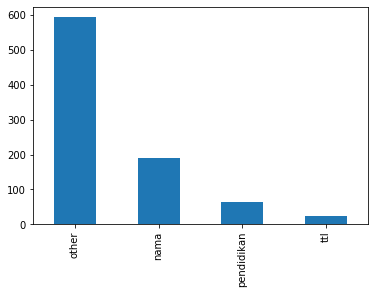

In [36]:
clean_train['label'].value_counts().plot(kind='bar')

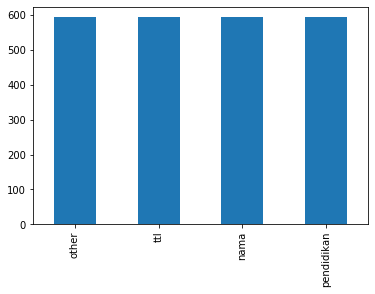

In [37]:
clean_train_oversampling['label'].value_counts().plot(kind='bar')

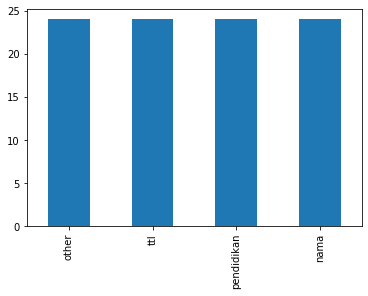

In [38]:
clean_train_downsampling['label'].value_counts().plot(kind='bar')

# testing perform of Bag of word

In [151]:
def test_model_bow(train,test):
    vectorizer = CountVectorizer()
    
    print("total data train : ",len(train))

    X_train, y_train = vectorizer.fit_transform(train["text"]).toarray() , train['label']
    X_test, y_test = vectorizer.transform(test["text"]).toarray() , test['label']

    clf = GaussianNB() 
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    #print(confusion_matrix(y_test, y_pred))
    return accuracy_score(y_test, y_pred)

In [152]:
def testing_fe_2(clean_train,clean_test):
    clean_train_nonsampling = clean_train
    clean_train_oversampling = oversampling(clean_train)
    clean_train_downsampling = downsampling(clean_train)
    
    acc_non = test_model_bow(clean_train_nonsampling,clean_test)
    acc_over = test_model_bow(clean_train_oversampling,clean_test)
    acc_under = test_model_bow(clean_train_downsampling,clean_test)

    
    print("ACCURACY")
    print("non sampling   : ",acc_non)
    print("over sampling  : ",acc_over)
    print("under sampling : ",acc_under)
    print("")
    return acc_non, acc_over, acc_under

In [153]:
print("### 1 epoch ###")
testing_fe_2(clean_train,clean_test)

### 1 epoch ###
total data train :  873
total data train :  2376
total data train :  96
ACCURACY
non sampling   :  0.7155963302752294
over sampling  :  0.7155963302752294
under sampling :  0.43119266055045874



(0.7155963302752294, 0.7155963302752294, 0.43119266055045874)

In [55]:
n_times = 10

avg_acc_non , avg_acc_over , avg_acc_under = [], [], []
for i in range(n_times):
    acc_non, acc_over, acc_under = testing_fe_2(clean_train,clean_test)
    avg_acc_non.append(acc_non)
    avg_acc_over.append(acc_over)
    avg_acc_under.append(acc_under)
    
print("")
print("############################################")
print("############################################")
print("ACCURACY {} times".format(n_times))
print("non sampling   : ",np.mean(avg_acc_non))
print("over sampling  : ",np.mean(avg_acc_over))
print("under sampling : ",np.mean(avg_acc_under))
    

total data train :  873
total data train :  2376
total data train :  2376
ACCURACY
non sampling   :  0.7155963302752294
over sampling  :  0.7155963302752294
under sampling :  0.7155963302752294

total data train :  873
total data train :  2376
total data train :  2376
ACCURACY
non sampling   :  0.7155963302752294
over sampling  :  0.7155963302752294
under sampling :  0.7155963302752294

total data train :  873
total data train :  2376
total data train :  2376
ACCURACY
non sampling   :  0.7155963302752294
over sampling  :  0.7155963302752294
under sampling :  0.7155963302752294

total data train :  873
total data train :  2376
total data train :  2376
ACCURACY
non sampling   :  0.7155963302752294
over sampling  :  0.7155963302752294
under sampling :  0.7155963302752294

total data train :  873
total data train :  2376
total data train :  2376
ACCURACY
non sampling   :  0.7155963302752294
over sampling  :  0.7155963302752294
under sampling :  0.7155963302752294

total data train :  873
t

In [156]:
def test_model_bow_plus_manual_Fe(train,test,verbose):
    print("total data train : ",len(train))
    
    vectorizer = CountVectorizer()
    X_train, y_train = vectorizer.fit_transform(train["text"]).toarray() , train['label']
    X_test, y_test = vectorizer.transform(test["text"]).toarray() , test['label']
    
    X_train_fe = [text_to_vector(i) for i in train["text"]]
    X_test_fe = [text_to_vector(i) for i in test["text"]]

    if verbose:
        print("X shape          : ",X_train.shape, " --------- ", X_test.shape)
    
    X_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_train_fe)], axis=1)
    X_test = pd.concat([pd.DataFrame(X_test), pd.DataFrame(X_test_fe)], axis=1)
    
    if verbose:
        print("X shape          : ",X_train.shape, " --------- ", X_test.shape)
    
    clf = GaussianNB() 
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [157]:
def testing_fe_3(clean_train,clean_test,verbose=False):
    clean_train_oversampling = oversampling(clean_train)
    clean_train_downsampling = downsampling(clean_train)

    acc_non = test_model_bow_plus_manual_Fe(clean_train,clean_test,verbose)
    acc_over = test_model_bow_plus_manual_Fe(clean_train_oversampling,clean_test,verbose)
    acc_under = test_model_bow_plus_manual_Fe(clean_train_downsampling,clean_test,verbose)

    
    print("ACCURACY")
    print("non sampling     : ",acc_non)
    print("over sampling    : ",acc_over)
    print("under sampling   : ",acc_under)
    print("")
    return acc_non, acc_over, acc_under

In [158]:
print("### 1 epoch ###")
testing_fe_3(clean_train,clean_test,True)

### 1 epoch ###
total data train :  873
X shape          :  (873, 2350)  ---------  (218, 2350)
X shape          :  (873, 2357)  ---------  (218, 2357)
total data train :  2376
X shape          :  (2376, 2350)  ---------  (218, 2350)
X shape          :  (2376, 2357)  ---------  (218, 2357)
total data train :  96
X shape          :  (96, 532)  ---------  (218, 532)
X shape          :  (96, 539)  ---------  (218, 539)
ACCURACY
non sampling     :  0.7339449541284404
over sampling    :  0.7339449541284404
under sampling   :  0.481651376146789



(0.7339449541284404, 0.7339449541284404, 0.481651376146789)

In [159]:
n_times = 10

avg_acc_non , avg_acc_over , avg_acc_under = [], [], []
for i in range(n_times):
    acc_non, acc_over, acc_under = testing_fe_3(clean_train,clean_test)
    avg_acc_non.append(acc_non)
    avg_acc_over.append(acc_over)
    avg_acc_under.append(acc_under)
    
print("")
print("############################################")
print("############################################")
print("ACCURACY {} times".format(n_times))
print("non sampling   : ",np.mean(avg_acc_non))
print("over sampling  : ",np.mean(avg_acc_over))
print("under sampling : ",np.mean(avg_acc_under))
    

total data train :  873
total data train :  2376
total data train :  96
ACCURACY
non sampling     :  0.7339449541284404
over sampling    :  0.7339449541284404
under sampling   :  0.42660550458715596

total data train :  873
total data train :  2376
total data train :  96
ACCURACY
non sampling     :  0.7339449541284404
over sampling    :  0.7339449541284404
under sampling   :  0.44954128440366975

total data train :  873
total data train :  2376
total data train :  96
ACCURACY
non sampling     :  0.7339449541284404
over sampling    :  0.7339449541284404
under sampling   :  0.44036697247706424

total data train :  873
total data train :  2376
total data train :  96
ACCURACY
non sampling     :  0.7339449541284404
over sampling    :  0.7339449541284404
under sampling   :  0.38990825688073394

total data train :  873
total data train :  2376
total data train :  96
ACCURACY
non sampling     :  0.7339449541284404
over sampling    :  0.7339449541284404
under sampling   :  0.44495412844036697

